# An Analysis of Linear and Non-Linear Mass - Spring-Damper Systems
# Harmonic Balance vs. Time Integration

In this notebook we perform time-integration of Duffing-like second order scalar ordinary differential equations (mass-spring-damper systems). Non-linearities can either be introduces in the damping or in the stiffness. We analyze the frequency content of the computed solution using the Fast Fourier Transform. 

The **goal** of this notebook is to explore how the non-linear term affects the frequency content of the computed solution (appearance of additional harmonics).  

## Import Libraries

In [76]:
using LinearAlgebra
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

## Section 1: Introduction  

To be extended. 

##  Section 2: Oscillating Mass-Spring System as Second Order ODE 

The example that follows was taken from here [https://stackoverflow.com/questions/60180865/2nd-order-odes-in-julia-using-differentialequations]. The way in which the problem is presented, however, contains a bug. Here we use the function `SecondOrderODEProblem` explained https://diffeq.sciml.ai/stable/solvers/dynamical_solve/ (solvers page) and https://diffeq.sciml.ai/stable/types/dynamical_types/ (problems page). 

In the notation of `SecondOrderODEProblem`, the velocity is numbered first. 

### Section 1.2: Time Integration 
Here we consider the linear harmonic oscillator without damping and without external forcing. The system is thus driven by the initial conditions.  

Resulting frequency of solution is eigenfrequency $\omega_0 = \sqrt{k/m}$ of the systems. This is confirmed by  FFT analysis of the solution. 

┌ Warning: Backwards compatability support of the new return codes to Symbols will be deprecated with the Julia v1.9 release. Please see https://docs.sciml.ai/SciMLBase/stable/interfaces/Solutions/#retcodes for more information
└ @ SciMLBase ~/.julia/packages/SciMLBase/QqtZA/src/retcodes.jl:355


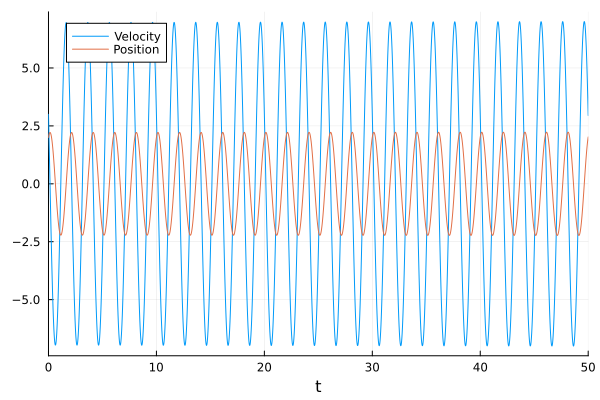

In [7]:
freq = .5
ω = 2 * π * freq                       

function mass_system!(ddu,u,p,t)
    # a(t) = -w^2 x 
    ddu = -(ω^2)*u 
end

v0    = 3.0                     
u0    = 2.0   
Tend  = 50
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)
sol  = solve(prob)
p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

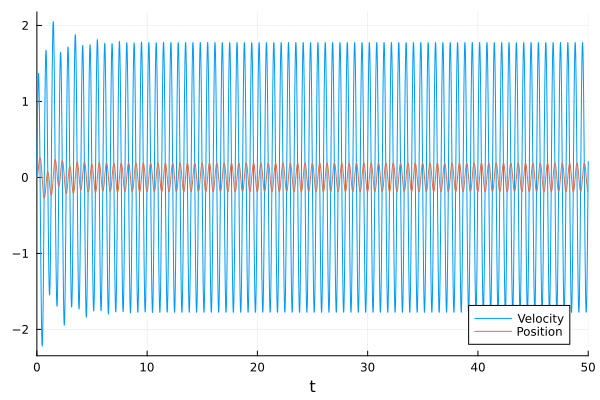

In [8]:
freq = .5
ω = 2 * π * freq                       

function mass_system(du,u,p,t)
    # a(t) = -w^2 x 
    ddu = -(ω^2)*u - du + 5*u^3 + 15*cos(3*ω*t)
end

v0    = 0. # 3.0                     
u0    = 0. # 2.0   
Tend  = 50
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system,v0,u0,tspan)
sol  = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8)
p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

### Section 2.2: Home-Brewed Post-Processing  

In [9]:
# retrieve solution at time step tstep 
tstep = 11
sol(tstep)

(-0.21114036964474292, 0.18639446173077184)

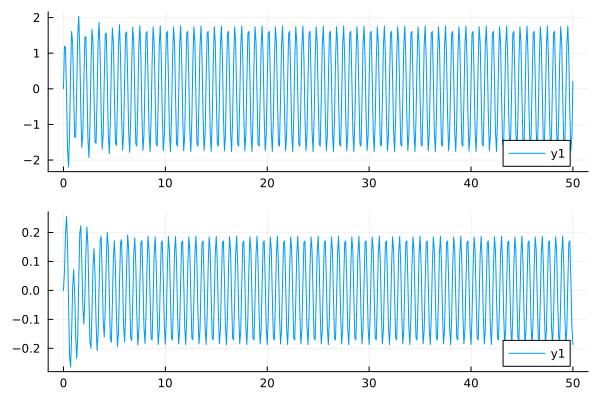

In [10]:
# retrieve velocity and position at specific sampling points 
Nsamples = 500
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]
p1 = plot(tsampled, vsampled)
p2 = plot(tsampled, usampled)
plot(p1,p2,layout = (2,1))

### Section 3.2: Spectral Analysis of the Time Domain Signal

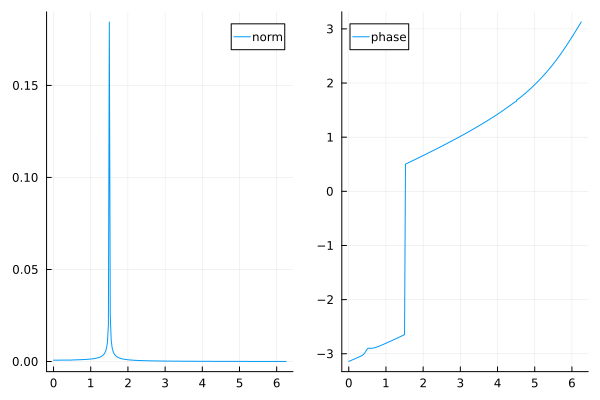

In [11]:
# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 10 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uf[1:length(fvec)]),label="phase")
plot(p1, p2)

## Section 3: Linear Damping and Periodic Forcing 

Is the harmonic balance method exact in case of **linear** damping? 

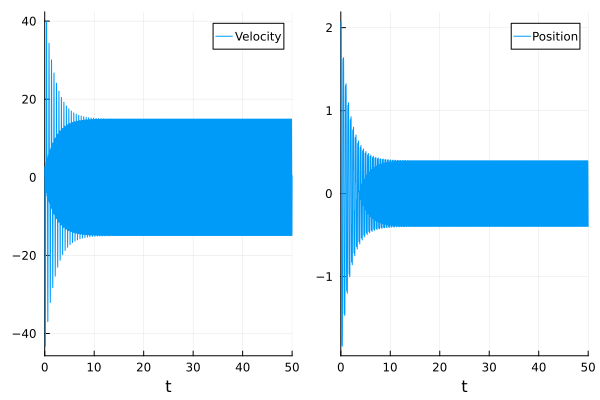

In [22]:
freq = 2.
ω = 2 * π * freq                       

function mass_system(du,u,p,t)
    ddu = -(ω^2)*u - du + 500*cos(3*ω*t) # include damping and harmonic forcing 
end

v0    = 0.                    
u0    = 2.0   
Tend  = 50
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system,v0,u0,tspan)
sol  = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8)
p1 = plot(sol,idxs=1,label="Velocity")
p2 = plot(sol,idxs=2,label="Position")
plot(p1,p2)

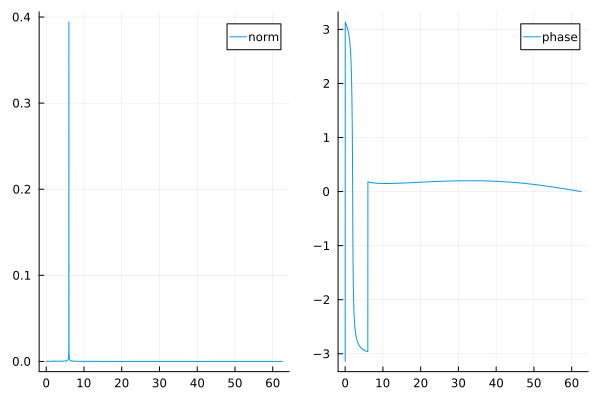

In [23]:
# retrieve velocity and position at specific sampling points 
Nsamples = 5000; #500
Tstart = 10 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uf[1:length(fvec)]),label="phase")
plot(p1, p2)

## Section 4: Attempt to reproduce Section 3 using Non-Linear Damping 
Should other powers in $u$ be used? Is the expression of the damping force correct? Solve non-linear equation for amplitude of the non-linear oscillation.     

In [1]:
freq = 2.
ω = 2 * π * freq                       

function mass_system(du,u,p,t)
    Fd = du*abs(du)
    # ddu = -(ω^2)*u - du + 500*cos(3*ω*t) # include damping and harmonic forcing 
    ddu = -(ω^2)*u - 5*Fd + 500*cos(3*ω*t) # include damping and harmonic forcing 
end

v0    = 0.                    
u0    = 2.0   
Tend  = 10
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system,v0,u0,tspan)
sol  = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8)
p1 = plot(sol,idxs=1,label="Velocity")
p2 = plot(sol,idxs=2,label="Position")
plot(p1,p2)

LoadError: UndefVarError: SecondOrderODEProblem not defined

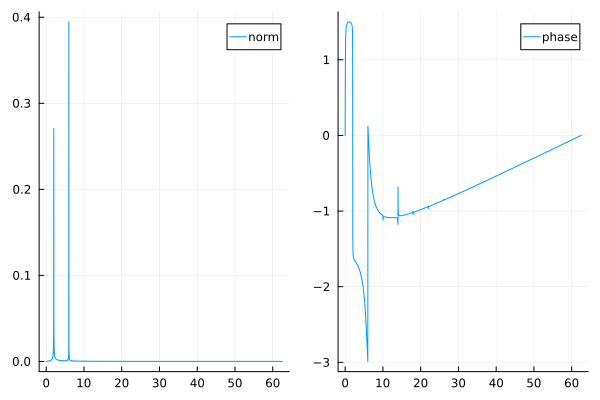

In [34]:
# retrieve velocity and position at specific sampling points 
Nsamples = 5000; #500
Tstart = 10 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uf[1:length(fvec)]),label="phase")
plot(p1, p2)

## Section 5: Other (Non)-Linear Damping and Periodic Forcing 
We observe that: 
1. forcing is shown to survice damping (as expected from periodically forcing the swing); 
2. eigenfrequency of the system dies out; 
3. harmonic content of the surviving signal is equal to harmonic content of the driving force; 

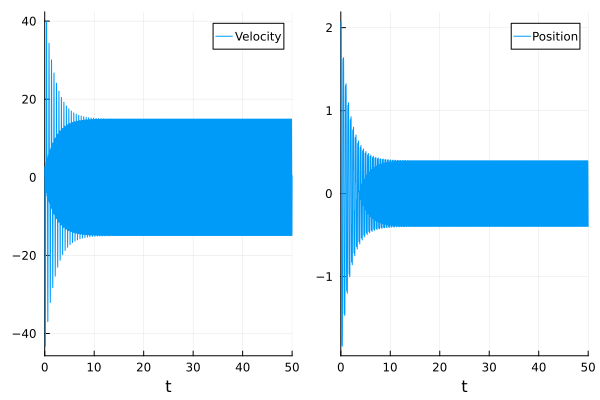

In [21]:
freq = 2. # .5
ω = 2 * π * freq                       

function mass_system(du,u,p,t)
    Fd = 2*u*du*(u>0) - 2*u*du*(u<0) 
    # ddu = -(ω^2)*u - du + 5*u^3 + 15*cos(3*ω*t)
    # ddu = -(ω^2)*u - du # include damping  
    ddu = -(ω^2)*u - du + 500*cos(3*ω*t) # include damping and harmonic forcing 
    # ddu = -(ω^2)*u - 10*abs(u)*du + 500*cos(3*ω*t) # include damping and harmonic forcing
    # ddu = -(ω^2)*u - Fd 
end

v0    = 0. # 3.0                     
u0    = 2.0   
Tend  = 50
tspan = (0.0,Tend)               

prob = SecondOrderODEProblem(mass_system,v0,u0,tspan)
sol  = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8)
p1 = plot(sol,idxs=1,label="Velocity")
p2 = plot(sol,idxs=2,label="Position")
plot(p1,p2)

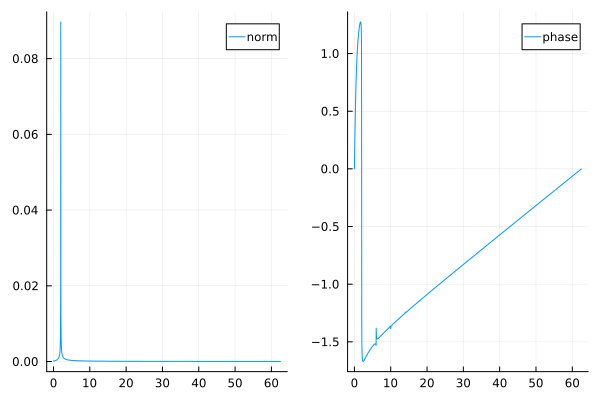

In [19]:
# retrieve velocity and position at specific sampling points 
Nsamples = 5000; #500
Tstart = 10 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uf[1:length(fvec)]),label="phase")
plot(p1, p2)

##  Section 6: Duffing Equation as Second Order ODE

### Section 1.6: Time Integration: No damping - No external forcing 
Larger amplitude of non-linear term causes larger peak in higher harmonic in the frequency domain. 

What should be the base frequency in the harmonic balance method: the fundamental frequency of the system or the frequency of the external exitation?   

In [ ]:
# code that follows clearly shows appearance of higher harmonics 

#..set frequency and angular frequency of the system 
freq = 1
ω = 1; # ω = 2 * π * freq                      

#..set initial velocity and in initial time 
v0 = 0.; # 3.0                     
u0 = 2.0    

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend)               

#..set rhs function of the ODE system 
function mass_system!(ddu,u,p,t)
    ddu = -(ω^2)*u + 0.22*u^3
    # ddu = -(ω^2)*u
end

#..set problem 
prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

#..plot computed velocity and position 
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

In [ ]:
# code that follows clearly shows appearance of higher harmonics 

#..set frequency and angular frequency of the system 
freq = 1
ω = 1; # ω = 2 * π * freq                      

#..set initial velocity and in initial time 
v0 = 0.; # 3.0                     
u0 = 2.0    

#..set end time and time interval 
Tend = 100.0 
tspan = (0.0,Tend)               

#..set rhs function of the ODE system 
function mass_system!(ddu,u,p,t)
    ddu = -(ω^2)*u + 0.22*u^3
    # ddu = -(ω^2)*u
end

#..set problem 
prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

#..plot computed velocity and position 
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

### Section 2.6: Spectral Analysis: No damping - No external forcing

In [ ]:
# retrieve velocity and position at specific sampling points 
Nsamples = 500
dt = Tend/Nsamples
tsampled = Vector(0:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
plot(fvec, 2.0/Nsamples * abs.(uf[1:length(fvec)])) 

## References 

1. Duffing equation: [wiki](https://en.wikipedia.org/wiki/Duffing_equation#CITEREFJordanSmith2007): provides details of harmonic balance method for single harmonic.  
2. Harmonic balance method applied to the Duffing equation: [youtube link](https://www.youtube.com/watch?v=4gCx4_RWeS8)